# Sorani Kurdish data visualisation using Plotly

## Setup

In [11]:
import pandas as pd
import locale, platform
import unicodedata as ud, regex as re
import plotly.express as px
import el_internationalisation as eli

## Helper functions

Open datasets often use the narrow set of Anglo-specific conventions that allows Python to recorgnise a number as either an integer or a floating point number. When scraping data from PDF files or web sites, it is possible to encounter other numeral systems. These numeral systems would not be recognised as integers or floating point numbers in Python, rather they would be treated as strings.

__convert_digits__ will convert a native number format into either an integer or floating point number. This can be applied as a post-processing step, or it can be applied as a converter when reading the data.

In [12]:
def convert_digits(s, sep = (",", ".")):
    nd = re.compile(r'^-?\p{Nd}[,.\u066B\u066C\u0020\u2009\u202F\p{Nd}]*$')
    tsep, dsep = sep
    if nd.match(s):
        s = s.replace(tsep, "")
        s = ''.join([str(ud.decimal(c, c)) for c in s])
        if dsep in s:
            return float(s.replace(dsep, ".")) if dsep != "." else float(s)
        return int(s)
    return s

seps = ("\u066C", "\u066B")
digitsconv = lambda x: convert_digits(x.replace("-", "٠"), sep = seps)

__convert_to_sorani_ns__ converts Western Arabic numerals, used by Python, to the Arabic flavour of Eastern Arabic numerals used in Sorani Kurdish.

In [13]:
def convert_to_sorani_ns(n, p=None, scale=None, trim=False):
    locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
    decimal_places = 2
    if trim:
        decimal_places = 0
    n = n * scale if scale else n
    format_string = '%0.' + str(decimal_places) + 'f' if type(n) == float else '%d'
    n = locale.format_string(format_string, n, grouping=True, monetary=True)
    n = n.replace(",", "ṯ").replace(".", "ḏ")
    sep = ["\u066C", "\u066B"]
    t = n.maketrans("0123456789", "٠١٢٣٤٥٦٧٨٩")
    locale.setlocale(locale.LC_ALL, "")
    return n.translate(t).replace("ṯ", sep[0] ).replace("ḏ", sep[1])

## Read data

In [14]:
conv = {
    'سووریا': digitsconv,
    'عێراق': digitsconv,
    'ئێران': digitsconv,
    'تورکیا': digitsconv,
    'جیھانی': digitsconv
}
df = pd.read_table("../data/demographics.tsv", converters=conv)
df

,---,جیھانی,تورکیا,ئێران,عێراق,سووریا
0,کرمانجی,14419000,7919000,443000,3185000,1661000
1,ئەوانەی بە تورکی دەدوێن,5732000,5732000,0,0,0
2,باشوور,3381000,0,3381000,0,0
3,سۆرانی,1576000,0,502000,567000,0
4,زازایی - دەملی,1125000,1125000,0,0,0
5,زازایی - ئەلڤێکا,184000,179000,0,0,0
6,ڕەوەند,90000,38000,20000,33000,0
7,ھەورامی,54000,0,26000,28000,0
8,شکاکی,49000,23000,26000,0,0
9,کۆی گشتی,26712000,15016000,4398000,3916000,1661000


In [15]:
col_list=["تورکیا" ,"ئێران" ,"عێراق" ,"سووریا"]
total_df = df[col_list].sum(axis=0)

print(total_df)

تورکیا    30032000
ئێران      8796000
عێراق      7729000
سووریا     3322000
dtype: int64


## Sorani Kurdish plot

1. Add Sorani Kurdish title label, and axes labels.
2. Mirror UI, if required.
3. Calculate `tickvals` and generate `ticktext` values by appling `convert_to_sorani_ns()` in order to convert Western Arabic digits to Eastern Arabic digits, scale numbers to millions, and trim numbers.

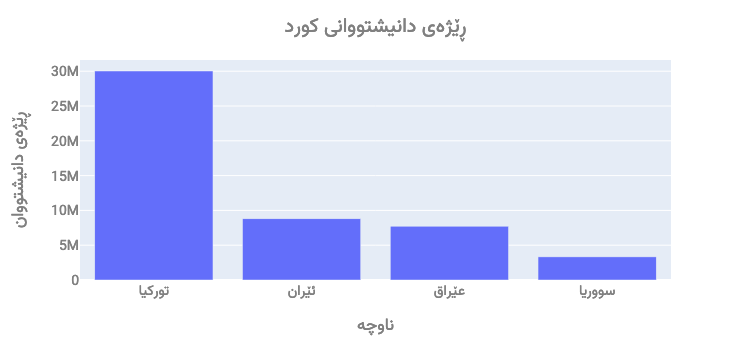

In [16]:
fig = px.bar(x=total_df.index, y=total_df.values)

fig.update_layout(
    title={
        'text': 'ڕێژەی دانیشتووانی کورد',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="ناوچە",
    yaxis_title="ڕێژەی دانیشتووان",
    font=dict(
        family="Vazirmatn",
        size=14,
        color="Grey"
    )
)

fig.show()

### Mirror UI

Update layout to:

1. Add dictionary for `xaxis`, providing axis label and set `autorange` value to _reverse_, to reverse the x-axis.
2. Add dictionary for `yaxis`, providing axis label and set axis to display on right side of plot.

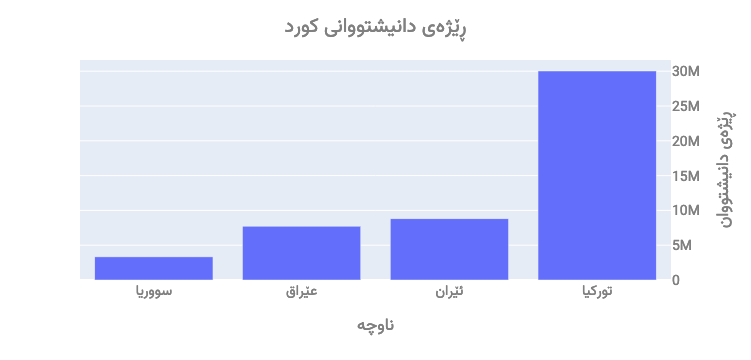

In [17]:
fig.update_layout(
    xaxis={
        "title":"ناوچە",
        "autorange": 'reversed'},
    yaxis={
        "title": "ڕێژەی دانیشتووان",
        "side": "right"},
)
fig.show()

### Convert digits

It is necessary to calculate the y-axis tick values, and convert them to Eastern Arabic numerals. To do this we need to know minimum and maximum values of the y-axiz tick values, and the increments used for tick values (dtick). `fig.layout.yaxis.dtick` will only return a vlaue if `dtick` is explicitly set. 

To get obtain the value used for `dtick`, it is necessary to use `fig.full_figure_for_development()`. In theory this function should not be used in a production environment, but it is currently the only way to programatically determine the axis tick values, unless `range` and `dtick` is explicitly set by the developer.

To use `fig.full_figure_for_development()`, the _kaleido_ package must be installed:

```zsh
pip3 install -U kaleido
```

An alternative is for the developer to manualy set the `range` and `dtick` values. This would avoid the need to use `fig.full_figure_for_development()` to determine the values auto-generated by Plotly.

In [18]:
%%capture
full_fig = fig.full_figure_for_development()

yaxis_range_min = int(full_fig.layout.yaxis.range[0])
yaxis_range_max = int(full_fig.layout.yaxis.range[1])
yaxis_dtick = int(full_fig.layout.yaxis.dtick)

yaxis_tickvals = [item for item in range(yaxis_range_min, yaxis_range_max, yaxis_dtick)]
yaxis_ticktext = [convert_to_sorani_ns(item, p=None, scale=0.000001, trim=True) for item in yaxis_tickvals]

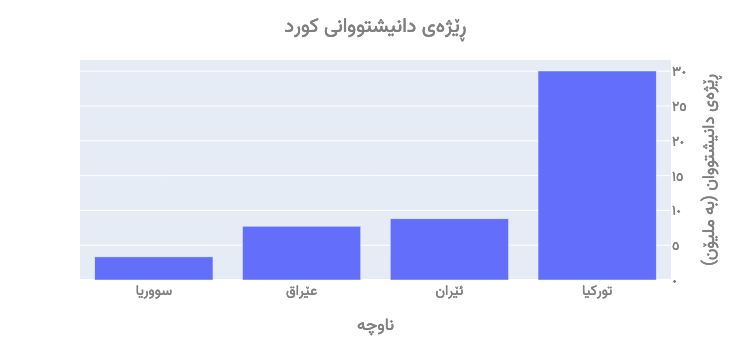

In [19]:
fig.update_layout(
    yaxis={
        "title": "ڕێژەی دانیشتووان (بە ملیۆن)",
        "tickmode": "array",
        "tickvals": yaxis_tickvals,
        "ticktext": yaxis_ticktext}
)
fig.show()